## Проект

Хотим обучить модель играть в игру atari Assault

In [1]:
# !pip uninstall tensorflow
# !pip install tensorflow==1.13.2


### Import

In [2]:
import random
import numpy as np
import torch
import utils
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%matplotlib inline

In [4]:
from Config.config3_ddqn import config #its our config

Посмотрим, как выглядит наша среда сейчас

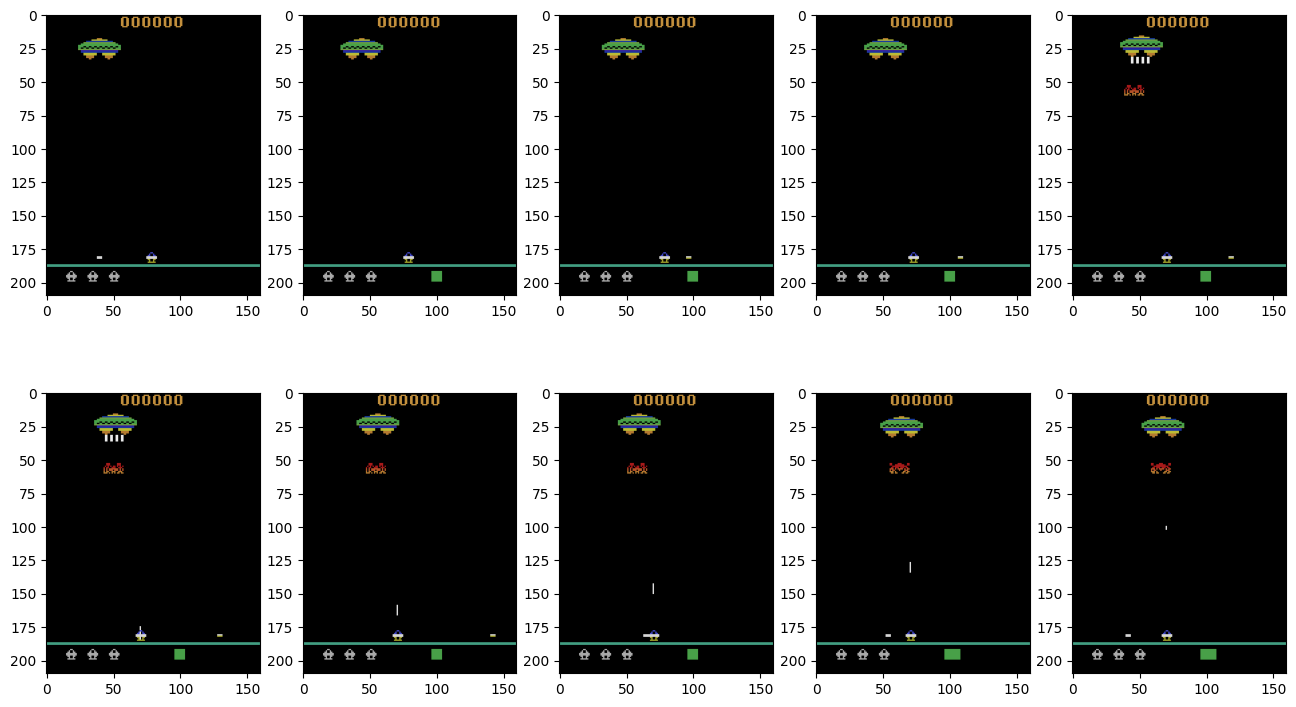

In [5]:
env = gym.make(config['env_name'])
env.reset()

n_cols = 5
n_rows = 2


fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render(mode="rgb_array"))
        env.step(env.action_space.sample())
plt.show()

Так как модели тяжело обучаться в RGB формате, а еще и при этом на 210x160 пикселях, давайте сделаем изображение черно-белым и сожмем его до размера 64x64

Также, так как в нашей среде есть снаряды, которыми стреляют враги и наш корабль, то логично сохранять последние 4 кадра, чтобы модель понимала характер движения объектов.

Также давайте уберем ненужные части (счет сверху и полоска жизней снизу)

Давайте, изменим нашу среду.

Formal tests seem fine. Here's an example of what you'll get.


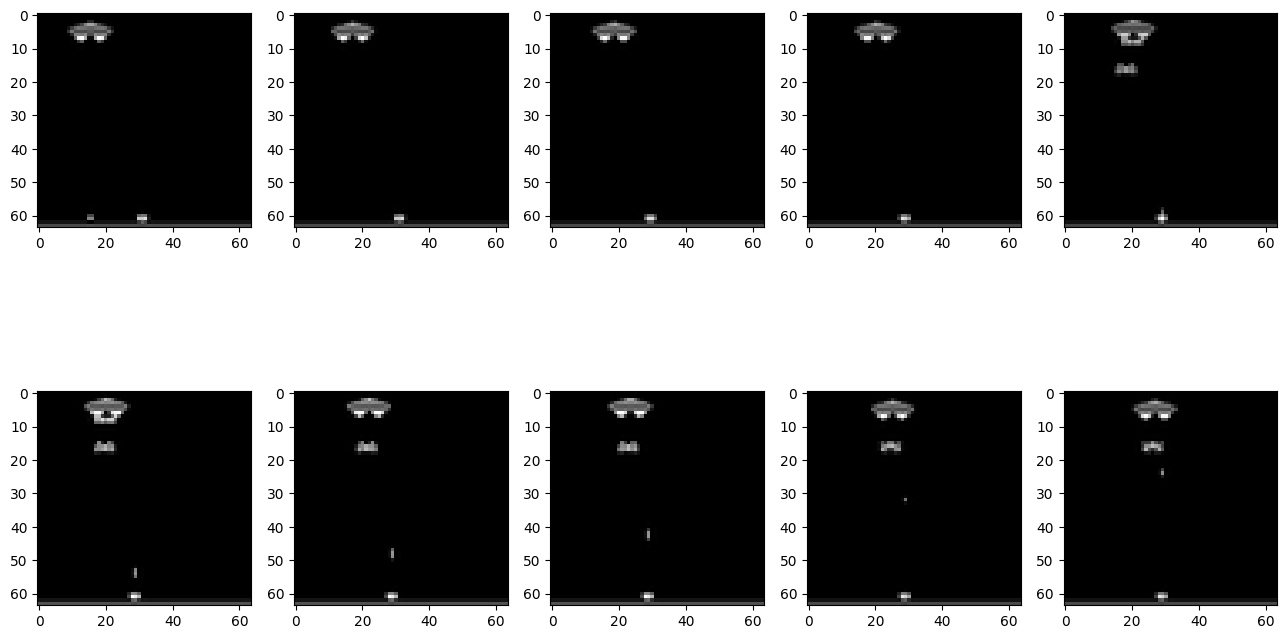

In [6]:
from Environment import PreprocessAtariObs, make_env

import gym
%matplotlib inline
# spawn game instance for tests
env = gym.make(config['env_name'])  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape, obs.shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"

# assert np.max(obs) >= 0.5, "It would be easier to see a brighter observation"
# assert np.mean(obs) >= 0.1, "It would be easier to see a brighter observation"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        # print(obs.shape)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()


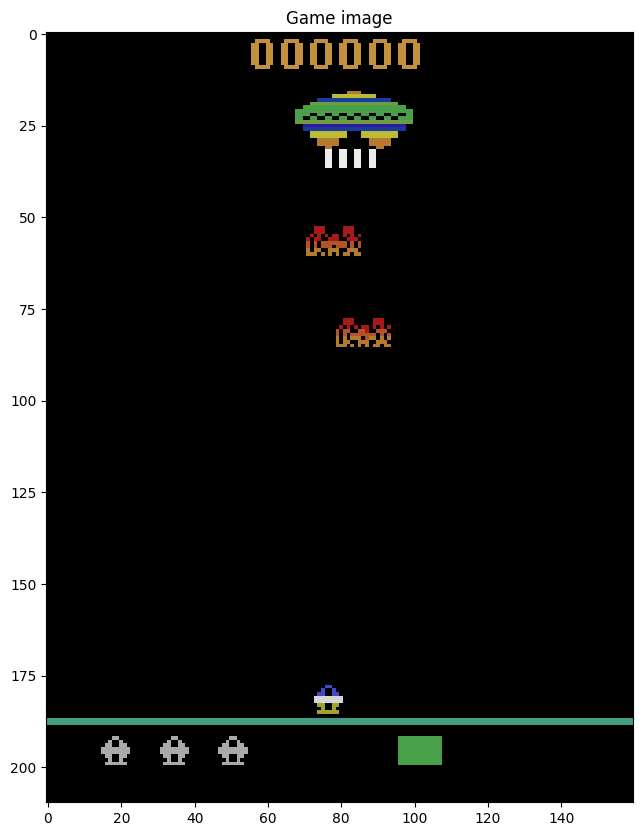

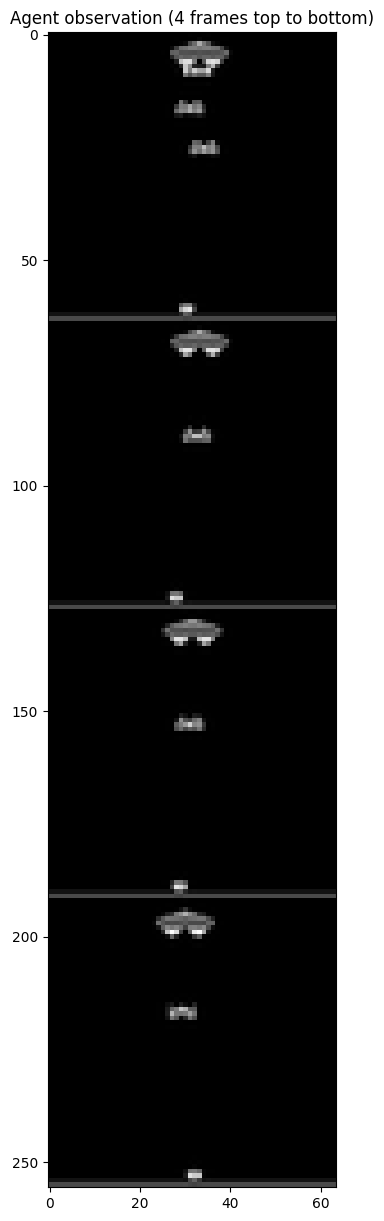

In [7]:
%matplotlib inline

env = make_env(skip=config['skip'])
env.reset()

n_actions = env.action_space.n
state_shape = env.observation_space.shape


for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())
%matplotlib inline

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

In [8]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [9]:
from DQNAgent import DQNAgent

agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

fc_size 1024
fc_size 1024


In [10]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [11]:
evaluate(env, agent, n_games=1)

c:\Users\User\Desktop\anthony\project_v2\DQNAgent.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  states = torch.tensor(states, device=model_device, dtype=torch.float32)


1.0

## Testing  replay buffer

In [12]:
from replay_buffer import ReplayBuffer
import numpy as np

replay_buffer = ReplayBuffer(3)


replay_buffer.add([3], 1, 1, [1], False)
# print(replay_buffer._next_idx)
replay_buffer.add([4], 2, 2, [2], True)
replay_buffer.add([5], 3, 3, [3], True)
# print(replay_buffer._next_idx)

# print(replay_buffer.storage)

# print(replay_buffer.sample(12, 0.0011))
# replay_buffer.update_priorities(np.array([0, 0, 1]), np.array([0.1, 1000, 135]))
print(replay_buffer.sample(5))

(array([[4],
       [5],
       [5],
       [4],
       [3]]), array([2, 3, 3, 2, 1]), array([2, 3, 3, 2, 1]), array([[2],
       [3],
       [3],
       [2],
       [1]]), array([ True,  True,  True,  True, False]))


In [13]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    for frame in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_state, r, done, _ = env.step(action)
        
        exp_replay.add(s, action, r, next_state, done)

        sum_rewards += r

        s = next_state

        if done:
            s = env.reset()

    return sum_rewards, s

In [14]:
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, \
    "play_and_record should have added exactly 1000 steps, " \
    "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, \
    "Please make sure you restart the game whenever it is 'done' and " \
    "record the is_done correctly into the buffer. Got %f is_done rate over " \
    "%i steps. [If you think it's your tough luck, just re-run the test]" % (
        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), \
        "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), \
        "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), \
        "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


In [15]:
def compute_prios(states, actions, rewards, next_states, is_done,
                    agent,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):

    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent.network(states)  # shape: [batch_size, n_actions]

    # compute q-values for all actions in next states
    predicted_next_qvalues = agent.target_network(next_states)  # shape: [batch_size, n_actions]
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    next_state_values = predicted_next_qvalues.max(1)[0]
    # print(states.shape)
    # print(next_states.shape)
    # print(next_state_values.shape)
    # print(next_state_values)

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    # mean squared error loss to minimize
    return abs((predicted_qvalues_for_actions - target_qvalues_for_actions)).detach() + 1e-6

In [16]:
def compute_td_loss(agent, exp_replay, batch_size, optimizer):
    gamma = config['gamma']
    states, actions, rewards, next_states, is_done = exp_replay.sample(batch_size)
    # print(idx)
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # idx = torch.tensor(idx, device=device, dtype=torch.int32) # shape: [batch_size]
    # print(idx)
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # print(states.shape)

    predicted_qvalues = agent.network(states)  # shape: [batch_size, n_actions]
    predicted_next_qvalues = agent.target_network(next_states)  # shape: [batch_size, n_actions]

    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]
    next_state_values = predicted_next_qvalues.max(1)[0]

    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    # diff = q_value - expected_q_value
    # prios = abs(diff) + 1e-6
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)
    # print(prios)

    # loss = prios * weights
    # loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [17]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [18]:
random.seed(config['seed'])
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])

In [19]:
def load():
    pass

In [20]:
def save():
    pass

In [21]:
env = make_env(config['seed'], skip=config['skip'])
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
exp_replay = ReplayBuffer(config['buffer_size'])

fc_size 1024
fc_size 1024


In [22]:
def fill_bufer(agent, N_STEPS=100):
    for i in range(config['buffer_size'] // N_STEPS):
      if not utils.is_enough_ram(min_available_gb=0.1):
          print("""
              Less than 100 Mb RAM available. 
              Make sure the buffer size in not too huge.
              Also check, maybe other processes consume RAM heavily.
              """
              )
          break
      play_and_record(state, agent, env, exp_replay, n_steps=N_STEPS)
      if len(exp_replay) == config['buffer_size']:
          break
      print("Length of buffer", len(exp_replay))

In [23]:
import time

def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

In [24]:
opt = torch.optim.Adam(agent.parameters(), lr=config['learning_rate'])

mean_rw_history = []
td_loss_history = []
initial_state_v_history = []
n_lives = 4
step = 0
best_score = -1

In [25]:
def plot_results():
    clear_output(True)
    print("buffer size = %i, epsilon = %.5f" %
        (len(exp_replay), agent.epsilon))

    plt.figure(figsize=[16, 9])

    plt.subplot(2, 2, 1)
    plt.title("Mean reward per life")
    plt.plot(mean_rw_history)
    plt.grid()

    assert not np.isnan(td_loss_history[-1])
    plt.subplot(2, 2, 2)
    plt.title("TD loss history (smoothened)")
    plt.plot(utils.smoothen(td_loss_history))
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.title("Initial state V")
    plt.plot(initial_state_v_history)
    plt.grid()
    plt.show()

Loading and saving

In [26]:
def load():
    global step, initial_state_v_history, td_loss_history, mean_rw_history
    checkpoint = torch.load(config['file_name'] , map_location=torch.device(device))
    best_score = checkpoint['best_score']
    agent.network.load_state_dict(checkpoint['network'])
    agent.target_network.load_state_dict(checkpoint['target_network'])
    opt.load_state_dict(checkpoint['optimizer'])
    step = checkpoint['step']
    initial_state_v_history = checkpoint['initial_state_v_history']
    td_loss_history = checkpoint['td_loss_history']
    mean_rw_history = checkpoint['mean_rw_history']

In [27]:
def save(step):

    torch.save({
        'step': step,
        'network': agent.network.state_dict(),
        'target_network': agent.target_network.state_dict(),
        'optimizer': opt,
        'best_score': best_score,
        'mean_rw_history': mean_rw_history,
        'td_loss_history': td_loss_history,
        'initial_state_v_history': initial_state_v_history
        }, config['file_name'])

buffer size = 20000, epsilon = 1.00000


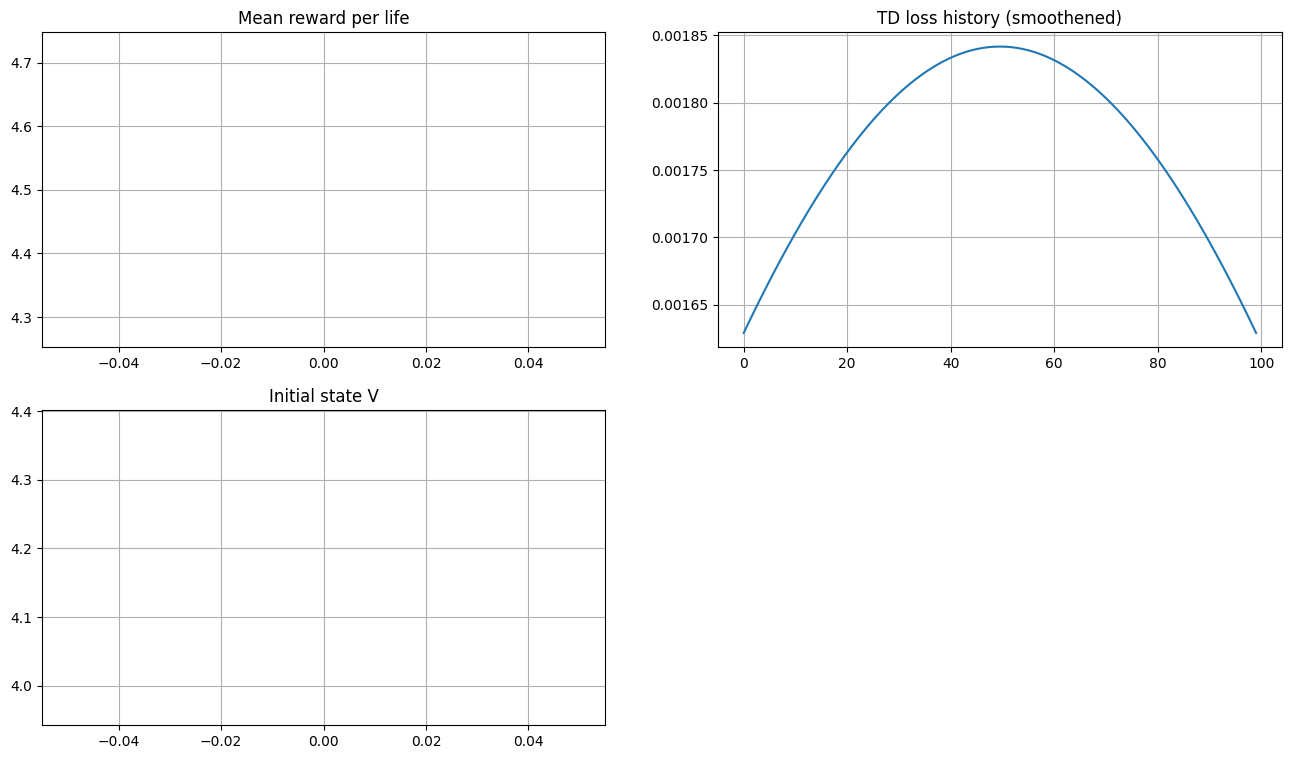

  0%|          | 4/3000001 [00:06<1014:07:35,  1.22s/it]

Saved successfully


  0%|          | 348/3000001 [00:15<20:12:15, 41.24it/s]

In [28]:
if config['loading']:
    try:
        load()
    except:
        pass
    fill_bufer(agent)
else:
    fill_bufer(agent)


state = env.reset()
with trange(step, config['total_steps'] + 1) as progress_bar:
    for step in progress_bar:
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everything is ok and use KeyboardInterrupt to continue')
            wait_for_keyboard_interrupt()

        agent.epsilon = utils.linear_decay(config['init_epsilon'], config['final_epsilon'], step, config['decay_steps'])
        beta = utils.linear_decay(config['init_beta'], config['final_beta'], step, config['decay_steps_beta'])

        # play
        _, state = play_and_record(state, agent, env, exp_replay, config['timesteps_per_epoch'])

        # train

        loss = compute_td_loss(agent, exp_replay, config['batch_size'], opt)

        if step % config['loss_freq'] == 0:
            td_loss_history.append(loss.data.cpu().item())

        if step % config['refresh_target_network_freq'] == 0:
            # Load agent weights into target_network
            agent.sync_target_network()
            print("refreshed target_network")
            # target_network.load_state_dict(agent.state_dict())

        if step % config['eval_freq'] == 0:
            reward = (evaluate(
                make_env(clip_rewards=True, seed=step, skip=config['skip']), agent, n_games=3 * n_lives, greedy=True)
            )

            if reward > best_score:
                best_score = reward
                torch.save({
                    'step': step,
                    'network': agent.network.state_dict(),
                    'target_network': agent.target_network.state_dict(),
                    'optimizer': opt,
                    'best_score': best_score,
                    'mean_rw_history': mean_rw_history,
                    'td_loss_history': td_loss_history,
                    'initial_state_v_history': initial_state_v_history
                }, 'best_score' + config['file_name'])


            mean_rw_history.append(reward)
            initial_state_q_values = agent.get_qvalues(
                [make_env(seed=step, skip=config['skip']).reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            plot_results()
        
        if step % config['steps_per_save'] == 0:
            save(step)
            print("Saved successfully")